# Interpretability of the Image Quality Metrics (IQMs) of MRIQC

[MRIQC](https://mriqc.readthedocs.io/en/latest/) is a powerful tool to assess the quality of MR images in a research study. In addition to a visual report, a number of image quality metrics (IQMs) are generated. However, there is a large number of these metrics and it is not immediately obvious which IQM a researcher should pay most attention to when deciding over the quality of a given image.

In this notebook, we will explore these issues in the MR-ART dataset, to provide researchers guidance in interpreting and selecting the most important IQMs from MRIQC.

In [61]:
# imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from plotly.subplots import make_subplots
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

First, let's import the data. The [Movement-Related Artifacts (MR-ART)](https://openneuro.org/datasets/ds004173) dataset contains the T1-weighted images of 148 healthy subjects (Nárai et al. 2022). Each subject has been acquired under three motion conditions:

1. no head movement
2. little head movement
3. much head movement

The motion was artifically induced by giving the subjects cues when to node their head.

The images were rated by to two expert neuroradiologists, who rated the images in their quality, with ratings

1. good quality
2. medium quality
3. bad quality.

The neuroradiologist were asked to harmonize their ratings, hence the dataset contains only one score per images.

In [62]:
# set path to the data
path_data = os.path.abspath("../data/")
# import IQMs
iqms = pd.read_csv(os.path.join(path_data, "IQMs.tsv"), index_col="bids_name", sep="\t")
# import rating scores
scores = pd.read_csv(os.path.join(path_data, "scores.tsv"), index_col="bids_name", sep="\t")
# make sure they are in the same order
iqms.sort_index(inplace=True)
scores.sort_index(inplace=True)

Let's combine the motion condition and the manual ratings in one dataframe:

In [63]:
def add_condition_column(scores):
    """Adds a column with the different movement conditions to the rating scores dataframe"""
    stand = scores.index.str.contains("standard")
    hm1 = scores.index.str.contains("motion1")
    hm2 = scores.index.str.contains("motion2")
    conditions = [
        (stand == True),
        (hm1 == True),
        (hm2 == True)]
    choices = [1, 2, 3]
    scores['condition'] = np.select(conditions, choices)
    return scores
scores = add_condition_column(scores)

## Rating scores and image conditions

We can explore how well the raters align in their scores with the motion condition. Does their rating reflect how much people moved in the scanner? Let's plot the confusion matrix of the scores assigned by the rater and the motion condition :

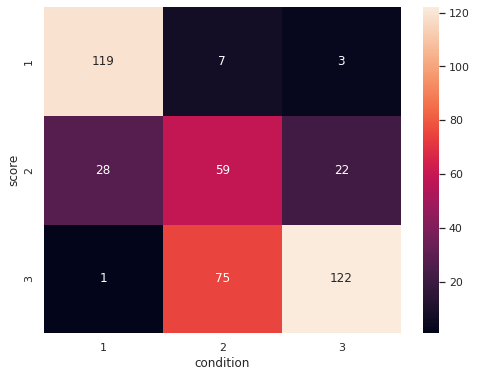

In [64]:
plt.figure(figsize=(8,6))
sns.heatmap(pd.crosstab(scores["score"], scores["condition"]), annot=True, fmt=".0f")
sns.set(font_scale=1)
plt.show()

We can see that generally there is good correspondance, with most values being on the main diagonal. Most confusion is for score 2, where there are also a lot of images from the no-motion as well as the much motion conditions.

Some images are however completely misclassified. We can visualize this using the library [Plotly](https://plotly.com/python/), which allows for creating a variety of interactive plots. With this, it will be easier to identify the images that were rated much better or much worse than the condition they were in.

In [65]:
px.strip(scores, x="condition", y="score", color=scores.index)

If you run this notebook yourself, you will be able to hover over the points to identify the subjects linked to each point. Because the markdown version of this notebook does not display Plotly's figures, we include them as images.

![ScoreVScondition](../figures/ScoreVScondition.png)

The graphing library `plotly` allows to color the points according to the name of the image, such that we can identify the outliers by hovering over them. We can see that image `sub-613957_acq-standard_T1W` got a bad rating, even though this was the image from the no-motion condition. 

For the three images `sub-253493_acq-headmotion2_T1w`, `sub-257563_acq-headmotion2_T1w`, and `sub-567742_acq-headmotion2_T1w` we have the opposite case: these images got the best rating, even though the subjects were supposed to move their heads a lot during the acquisition of these images.

Try and look at the HTML reports of these images: can you guess what was likely going on in each of these cases?

## Visualizing the IQMs

Next, let's look at the IQMs. There are many different variables here:

### Preprocessing the IQMs

In [66]:
iqms.columns

Index(['cjv', 'cnr', 'efc', 'fber', 'fwhm_avg', 'fwhm_x', 'fwhm_y', 'fwhm_z',
       'icvs_csf', 'icvs_gm', 'icvs_wm', 'inu_med', 'inu_range', 'qi_1',
       'qi_2', 'rpve_csf', 'rpve_gm', 'rpve_wm', 'size_x', 'size_y', 'size_z',
       'snr_csf', 'snr_gm', 'snr_total', 'snr_wm', 'snrd_csf', 'snrd_gm',
       'snrd_total', 'snrd_wm', 'spacing_x', 'spacing_y', 'spacing_z',
       'summary_bg_k', 'summary_bg_mad', 'summary_bg_mean',
       'summary_bg_median', 'summary_bg_n', 'summary_bg_p05', 'summary_bg_p95',
       'summary_bg_stdv', 'summary_csf_k', 'summary_csf_mad',
       'summary_csf_mean', 'summary_csf_median', 'summary_csf_n',
       'summary_csf_p05', 'summary_csf_p95', 'summary_csf_stdv',
       'summary_gm_k', 'summary_gm_mad', 'summary_gm_mean',
       'summary_gm_median', 'summary_gm_n', 'summary_gm_p05', 'summary_gm_p95',
       'summary_gm_stdv', 'summary_wm_k', 'summary_wm_mad', 'summary_wm_mean',
       'summary_wm_median', 'summary_wm_n', 'summary_wm_p05', 'summary_wm

Some of them we can get rid of right away, as they are not image quality metrics, but measurement parameters.

In [67]:
iqms_use = iqms.drop(["size_x", "size_y", "size_z", "spacing_x", "spacing_y", "spacing_z"], axis=1)

We should also normalize the data, as the units of the IQMs vary wildly. This is required by some methods like PCA down the line, but it also makes sense computationally to have all values in the same order of magnitude.

In [68]:
scaler = StandardScaler()
iqms_scaled = scaler.fit_transform(iqms_use)
iqms_scaled = pd.DataFrame(iqms_scaled, columns=iqms_use.columns, index=iqms_use.index)

Now that we preprocessed our IQMs, let us combine the IQMs, the manual ratings and the motion condition in one dataframe to more easily use it in our analysis.

In [69]:
#We merge the dataframes based on their indexes, which corresponds to the bids name of each scan
data_df = pd.merge(left=scores, left_index=True, right=iqms_scaled, right_index=True)
data_df

score  condition       cjv       cnr  \
bids_name                                                              
sub-000103_acq-headmotion1_T1w      2          2 -0.891671  1.023455   
sub-000103_acq-headmotion2_T1w      3          3  0.322492 -0.481170   
sub-000103_acq-standard_T1w         1          1 -1.198496  1.446902   
sub-000148_acq-headmotion1_T1w      3          2  0.607133 -0.728387   
sub-000148_acq-headmotion2_T1w      3          3  0.089333 -0.168848   
...                               ...        ...       ...       ...   
sub-992121_acq-headmotion2_T1w      2          3 -0.574475  0.459102   
sub-992121_acq-standard_T1w         1          1 -1.165106  1.337207   
sub-992238_acq-headmotion1_T1w      3          2 -0.336329  0.212102   
sub-992238_acq-headmotion2_T1w      3          3  0.744436 -0.927664   
sub-992238_acq-standard_T1w         1          1 -1.131714  1.398085   

                                     efc      fber  fwhm_avg    fwhm_x  \
bids_name                                                                
sub-000103_acq-headmotion1_T1w  0.379405  0.946453  0.123567 -0.157856   
sub-000103_acq-headmotion2_T1w  0.801350  0.170918 -0.342638 -0.669880   
sub-000103_acq-standard_T1w     0.075100 -0.946513  0.006137 -0.202609   
sub-000148_acq-headmotion1_T1w  0.555687 -0.404468 -0.297952 -0.207820   
sub-000148_acq-headmotion2_T1w  0.483471  0.159432 -0.103982  0.047497   
...                                  ...       ...       ...       ...   
sub-992121_acq-headmotion2_T1w  1.106414  0.149363  0.181063  0.342071   
sub-992121_acq-standard_T1w     0.707725 -0.946513  0.806795  0.998398   
sub-992238_acq-headmotion1_T1w  0.022202  0.914001  0.424312  0.288854   
sub-992238_acq-headmotion2_T1w  0.535875  0.505978 -0.087667 -0.188586   
sub-992238_acq-standard_T1w    -0.721208 -0.946513  0.174032  0.137035   

                                  fwhm_y    fwhm_z  ...  summary_wm_mean  \
bids_name                                           ...                    
sub-000103_acq-headmotion1_T1w  0.347641  0.133998  ...        -0.579687   
sub-000103_acq-headmotion2_T1w -0.226566 -0.081536  ...         0.749833   
sub-000103_acq-standard_T1w     0.214003 -0.030905  ...        -0.784952   
sub-000148_acq-headmotion1_T1w -0.367656 -0.273105  ...         0.650114   
sub-000148_acq-headmotion2_T1w -0.213522 -0.119734  ...         0.115257   
...                                  ...       ...  ...              ...   
sub-992121_acq-headmotion2_T1w  0.267109 -0.137932  ...        -0.656950   
sub-992121_acq-standard_T1w     0.969088  0.277350  ...        -0.844802   
sub-992238_acq-headmotion1_T1w  0.540691  0.374432  ...         0.177875   
sub-992238_acq-headmotion2_T1w -0.088070  0.038501  ...         1.002042   
sub-992238_acq-standard_T1w     0.358339 -0.047950  ...        -1.000083   

                                summary_wm_median  summary_wm_n  \
bids_name                                                         
sub-000103_acq-headmotion1_T1w          -0.328985      0.664616   
sub-000103_acq-headmotion2_T1w          -0.179988      0.977603   
sub-000103_acq-standard_T1w             -0.338320      0.498901   
sub-000148_acq-headmotion1_T1w           0.948030     -0.288896   
sub-000148_acq-headmotion2_T1w           0.825849     -0.256005   
...                                           ...           ...   
sub-992121_acq-headmotion2_T1w          -0.172442      0.747438   
sub-992121_acq-standard_T1w             -0.259740      0.359484   
sub-992238_acq-headmotion1_T1w           0.370348      0.767916   
sub-992238_acq-headmotion2_T1w          -0.535891      0.727136   
sub-992238_acq-standard_T1w             -0.697419      0.331397   

                                summary_wm_p05  summary_wm_p95  \
bids_name                                                        
sub-000103_acq-headmotion1_T1w        0.699918       -0.661274   
sub-000103_acq-headmotion2_T1w       -0.253814        0.485443   
sub-000

### Visualizing the data (always!)

Rule number one of data analysis: always visualize your data! We can plot the pairwise scatterplots to get an idea of the relationships between the IQMs. There are quite a few IQMs, so plottings this might take a few minutes, depending on your hardware.

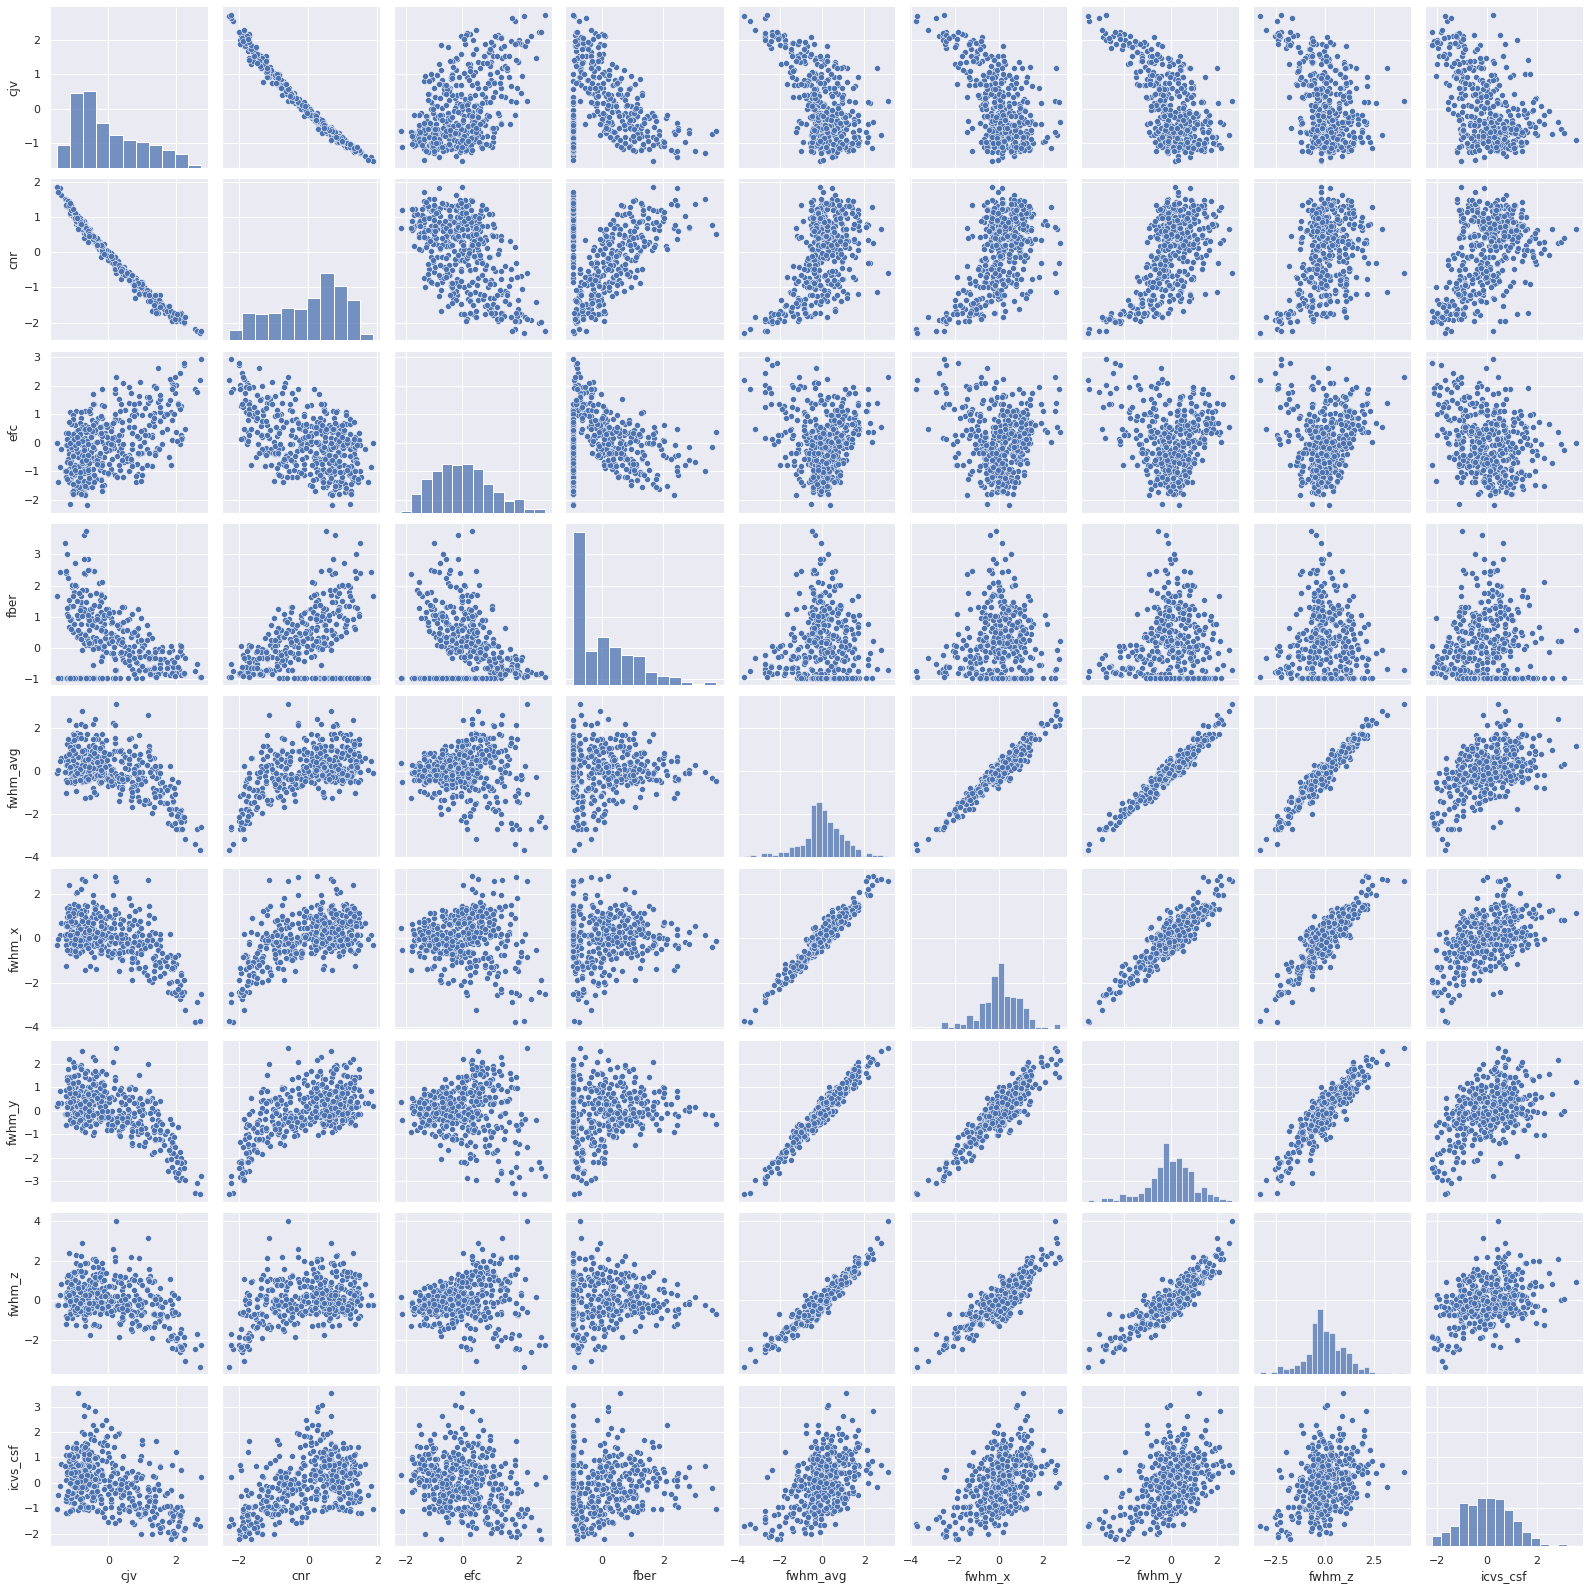

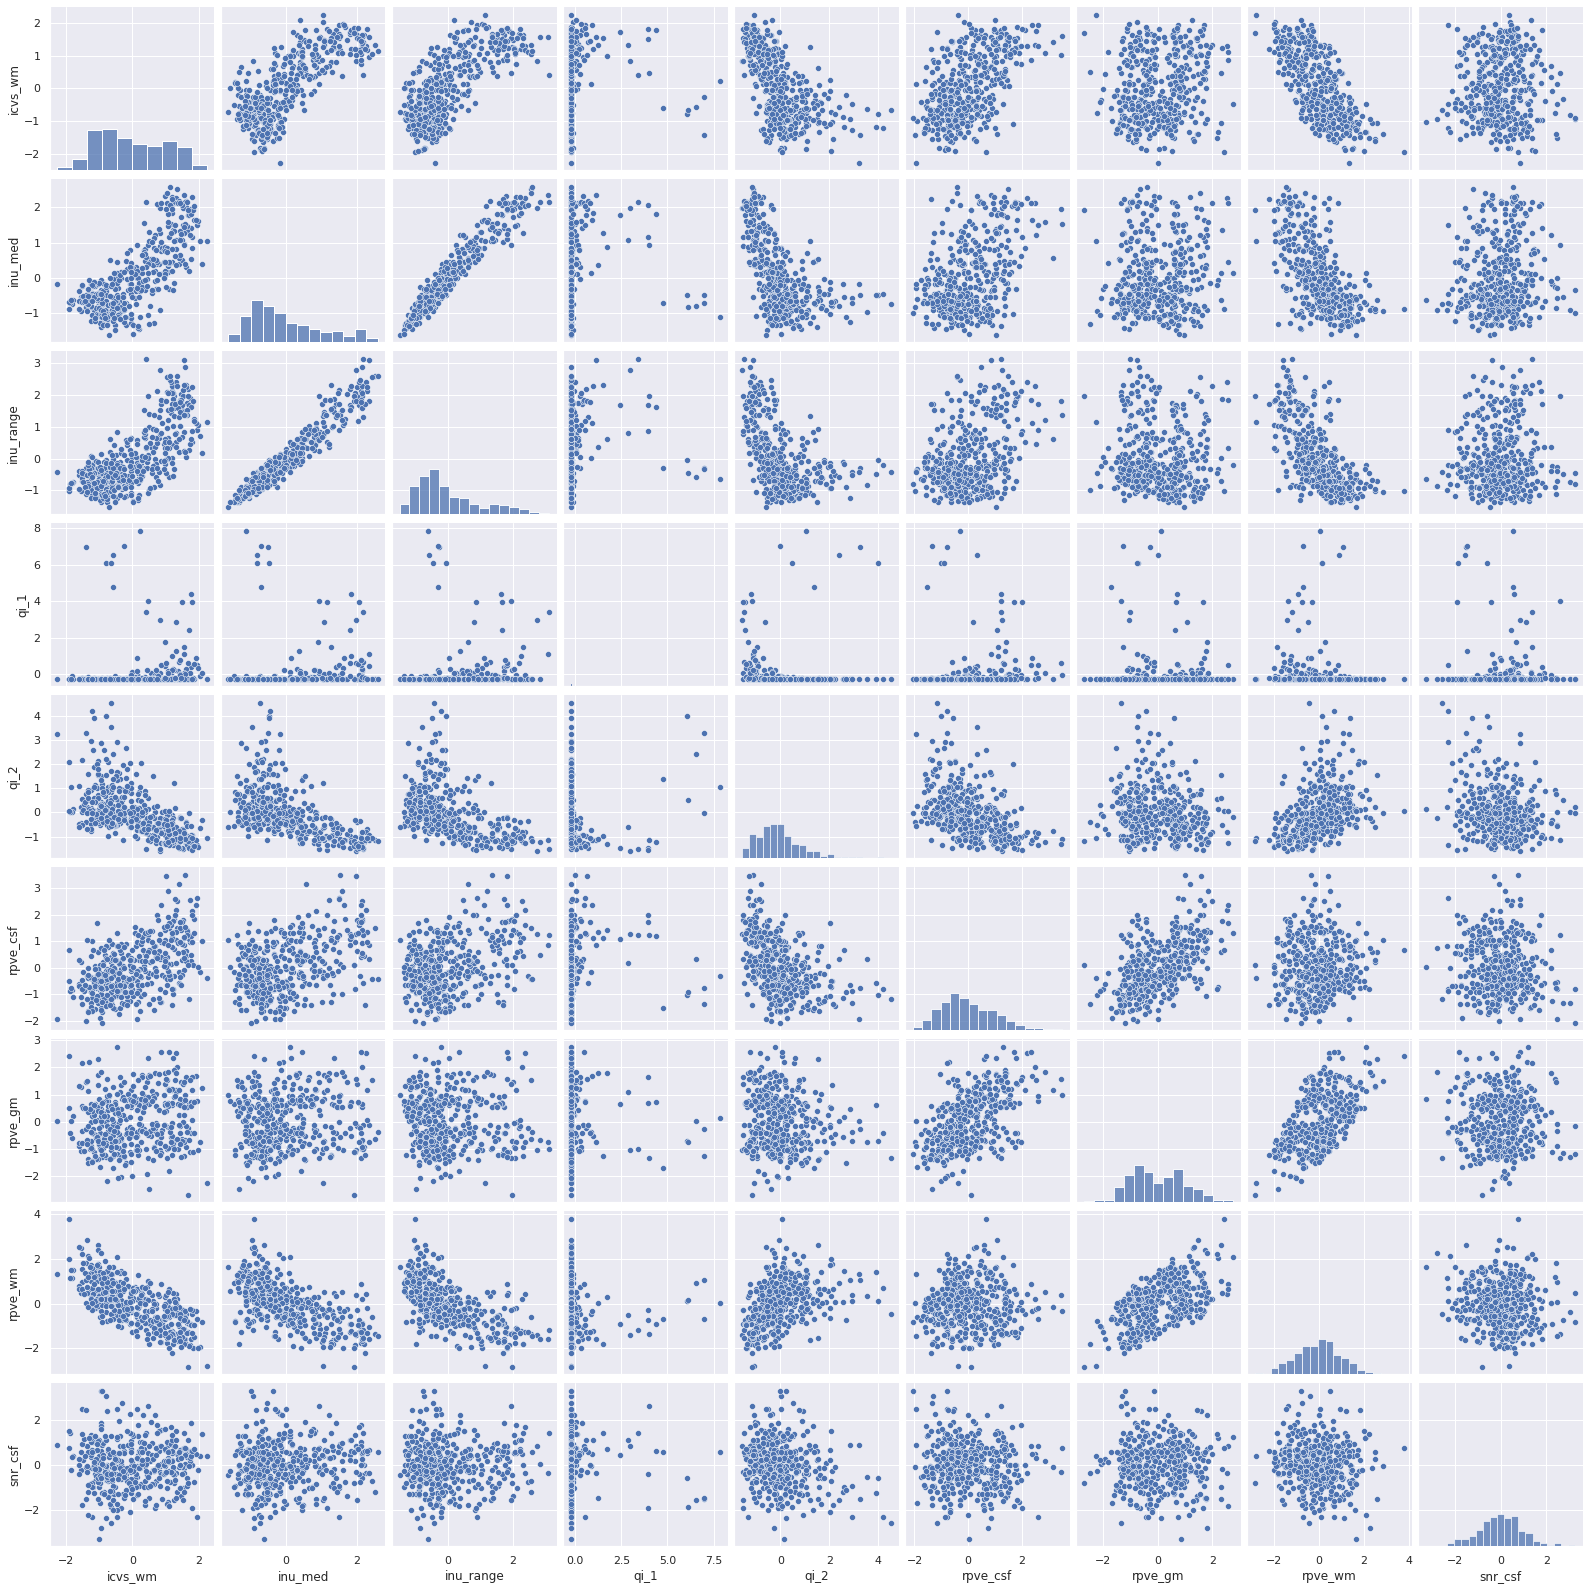

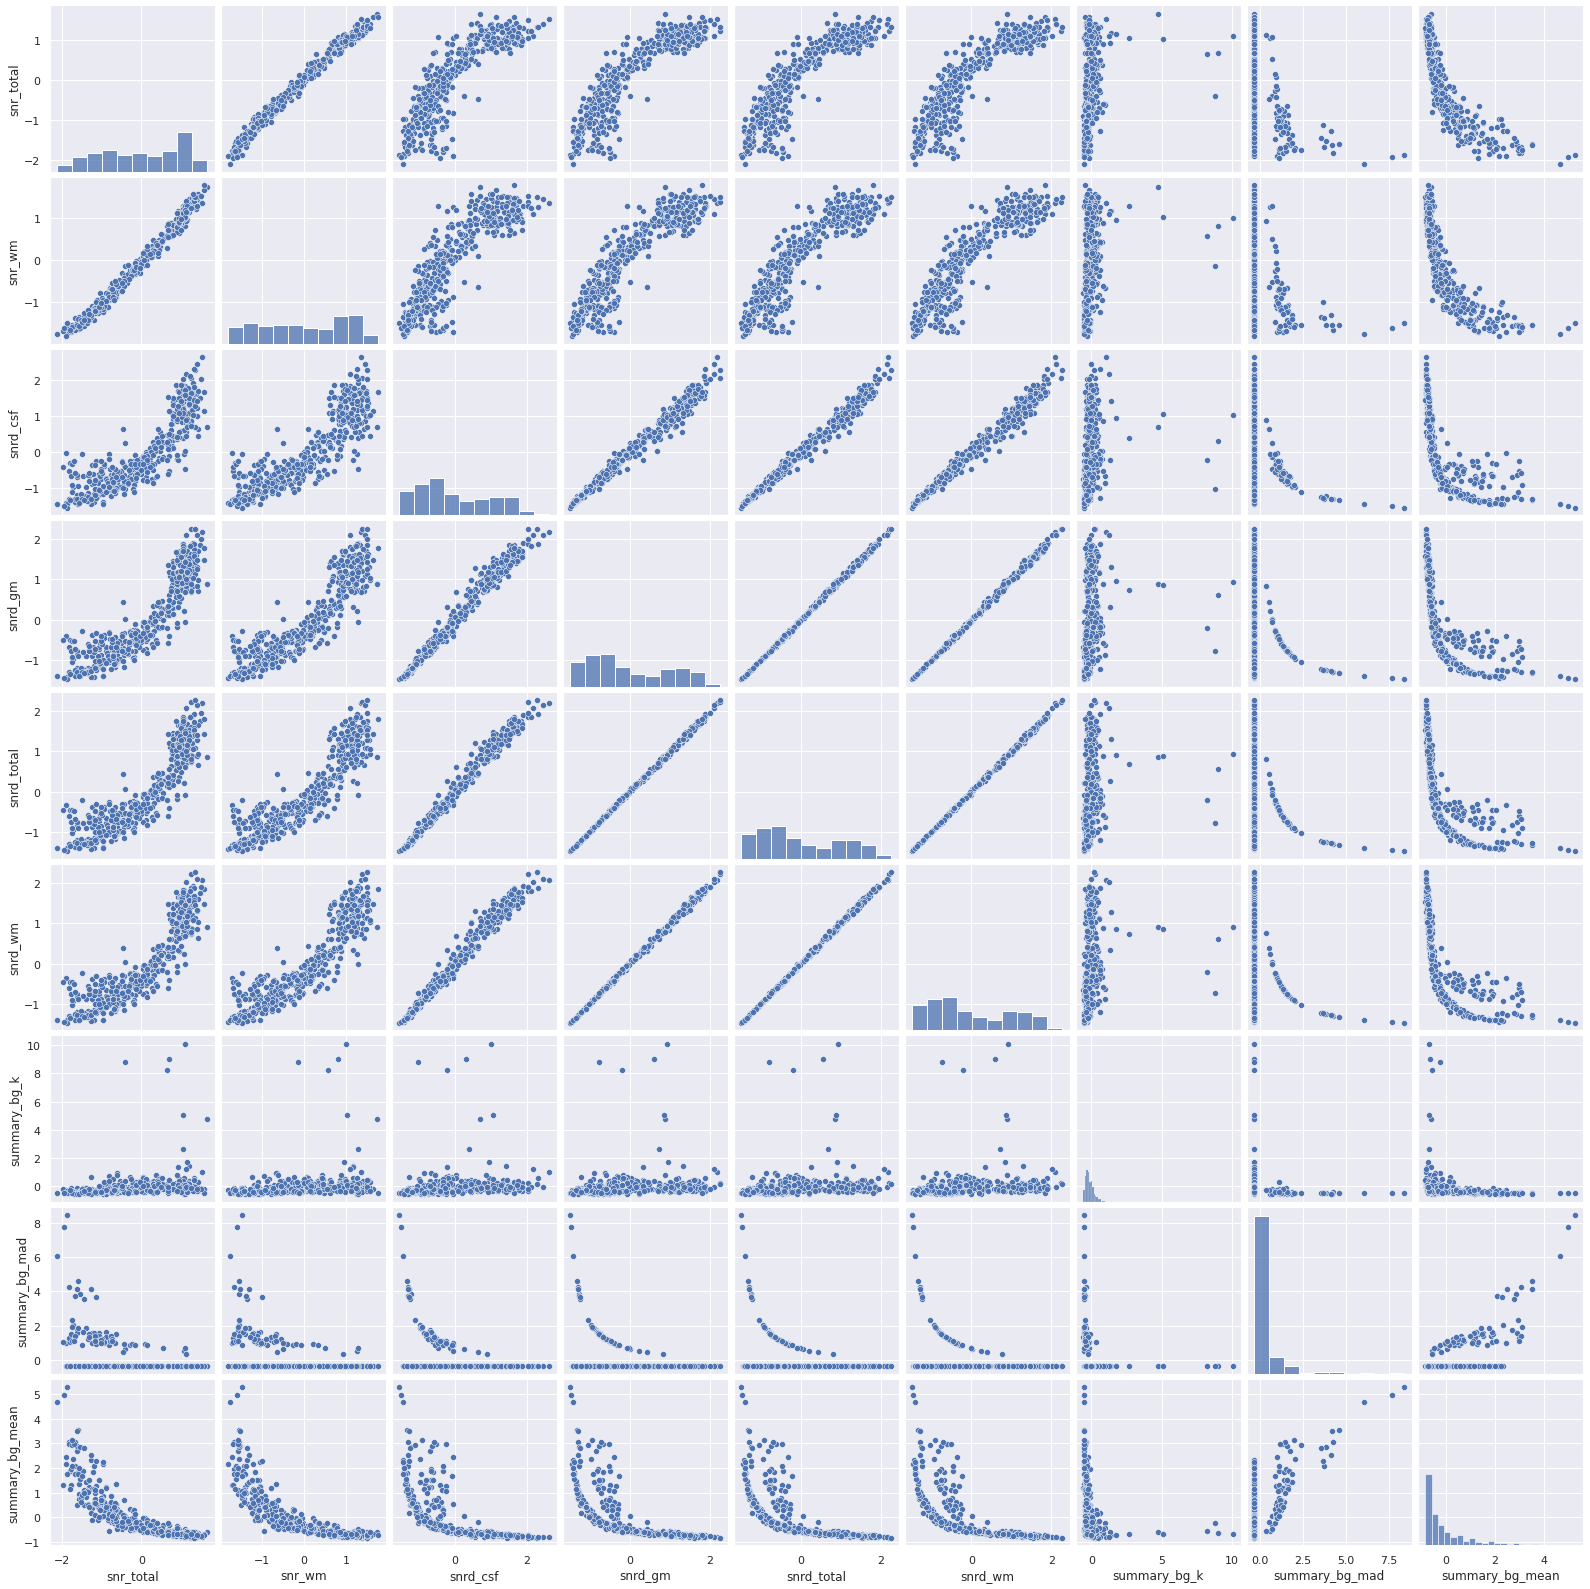

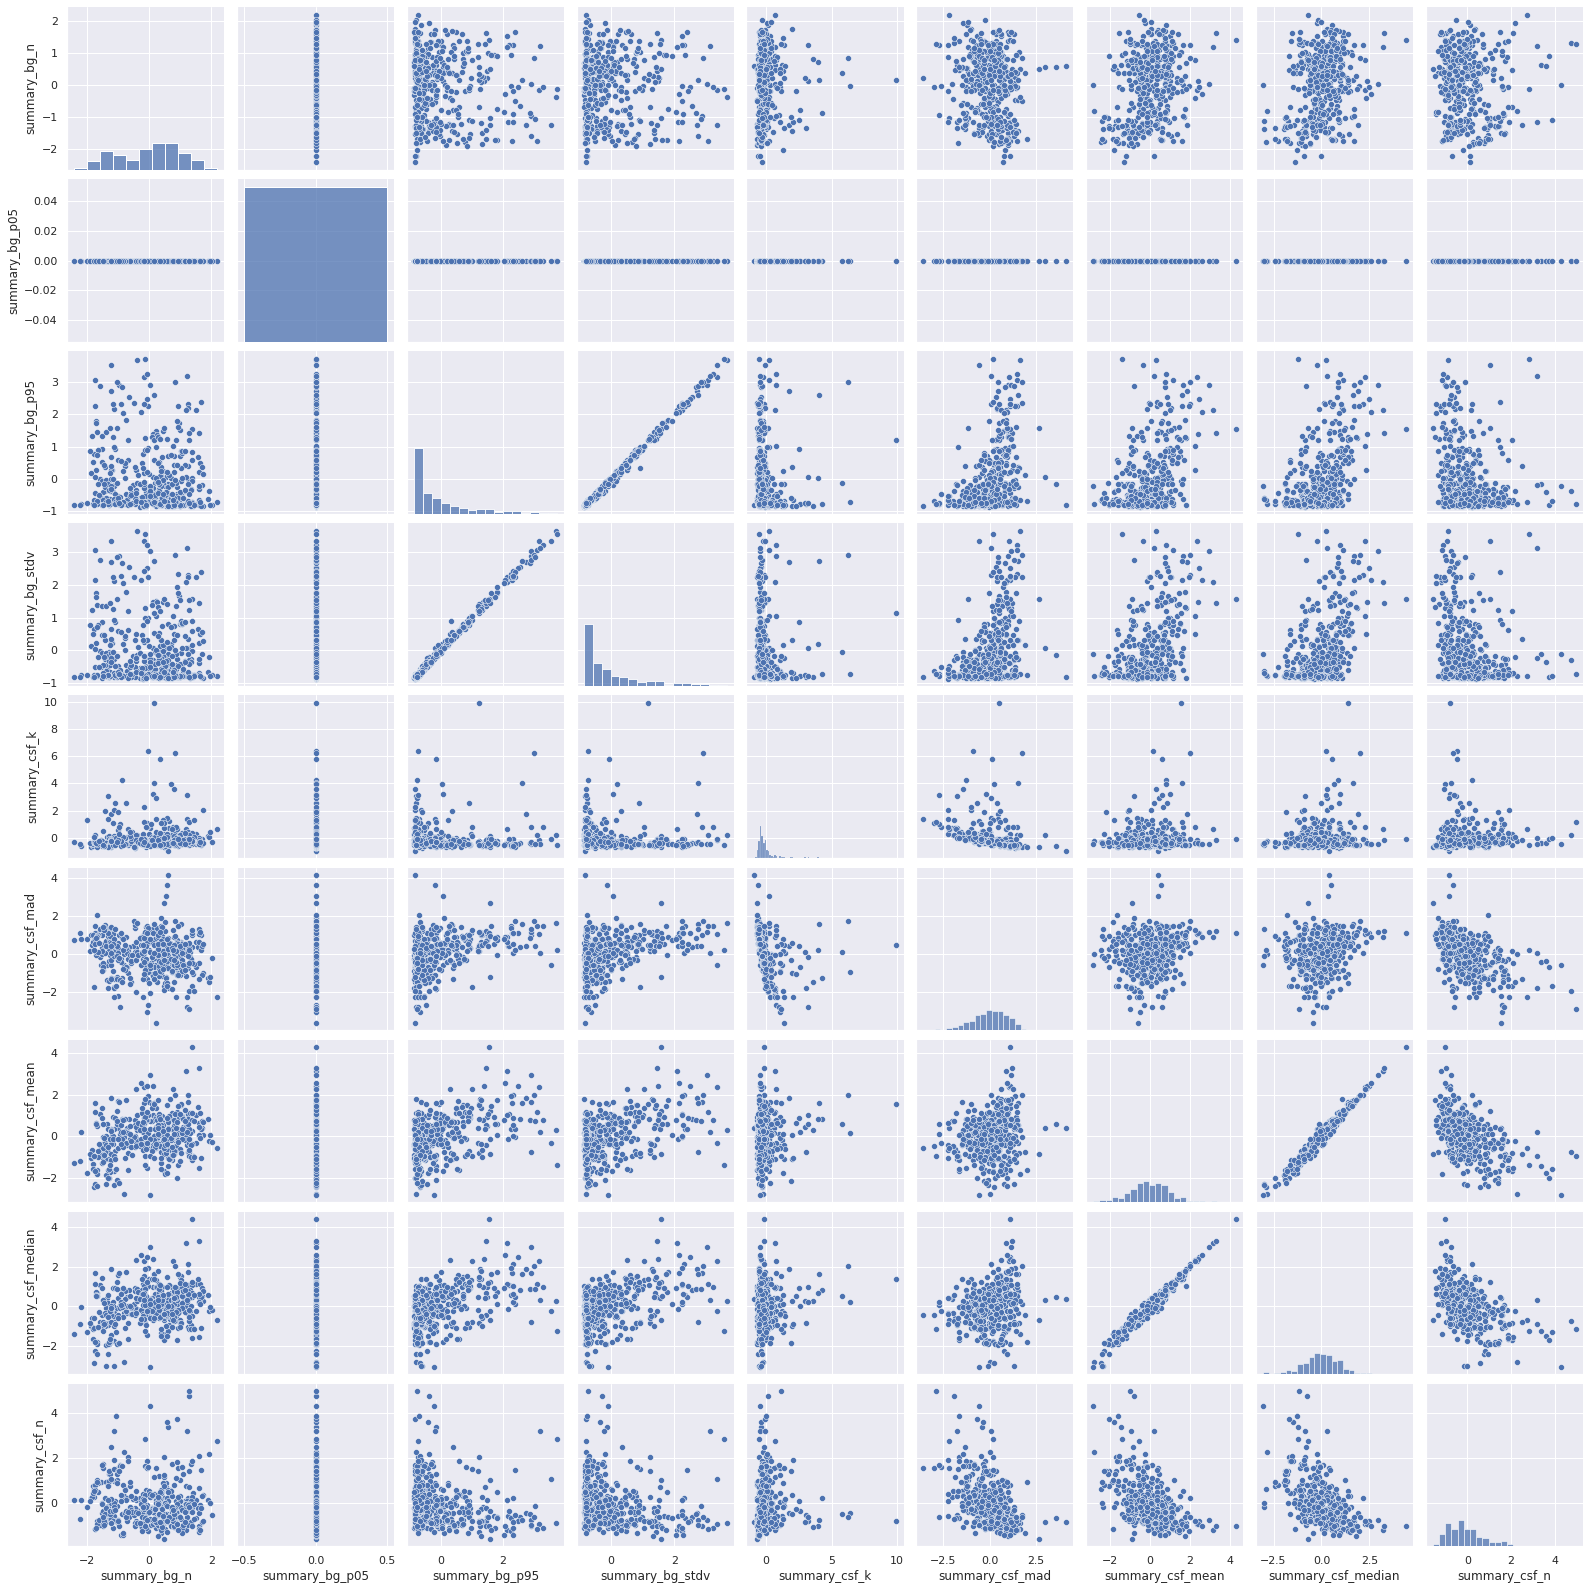

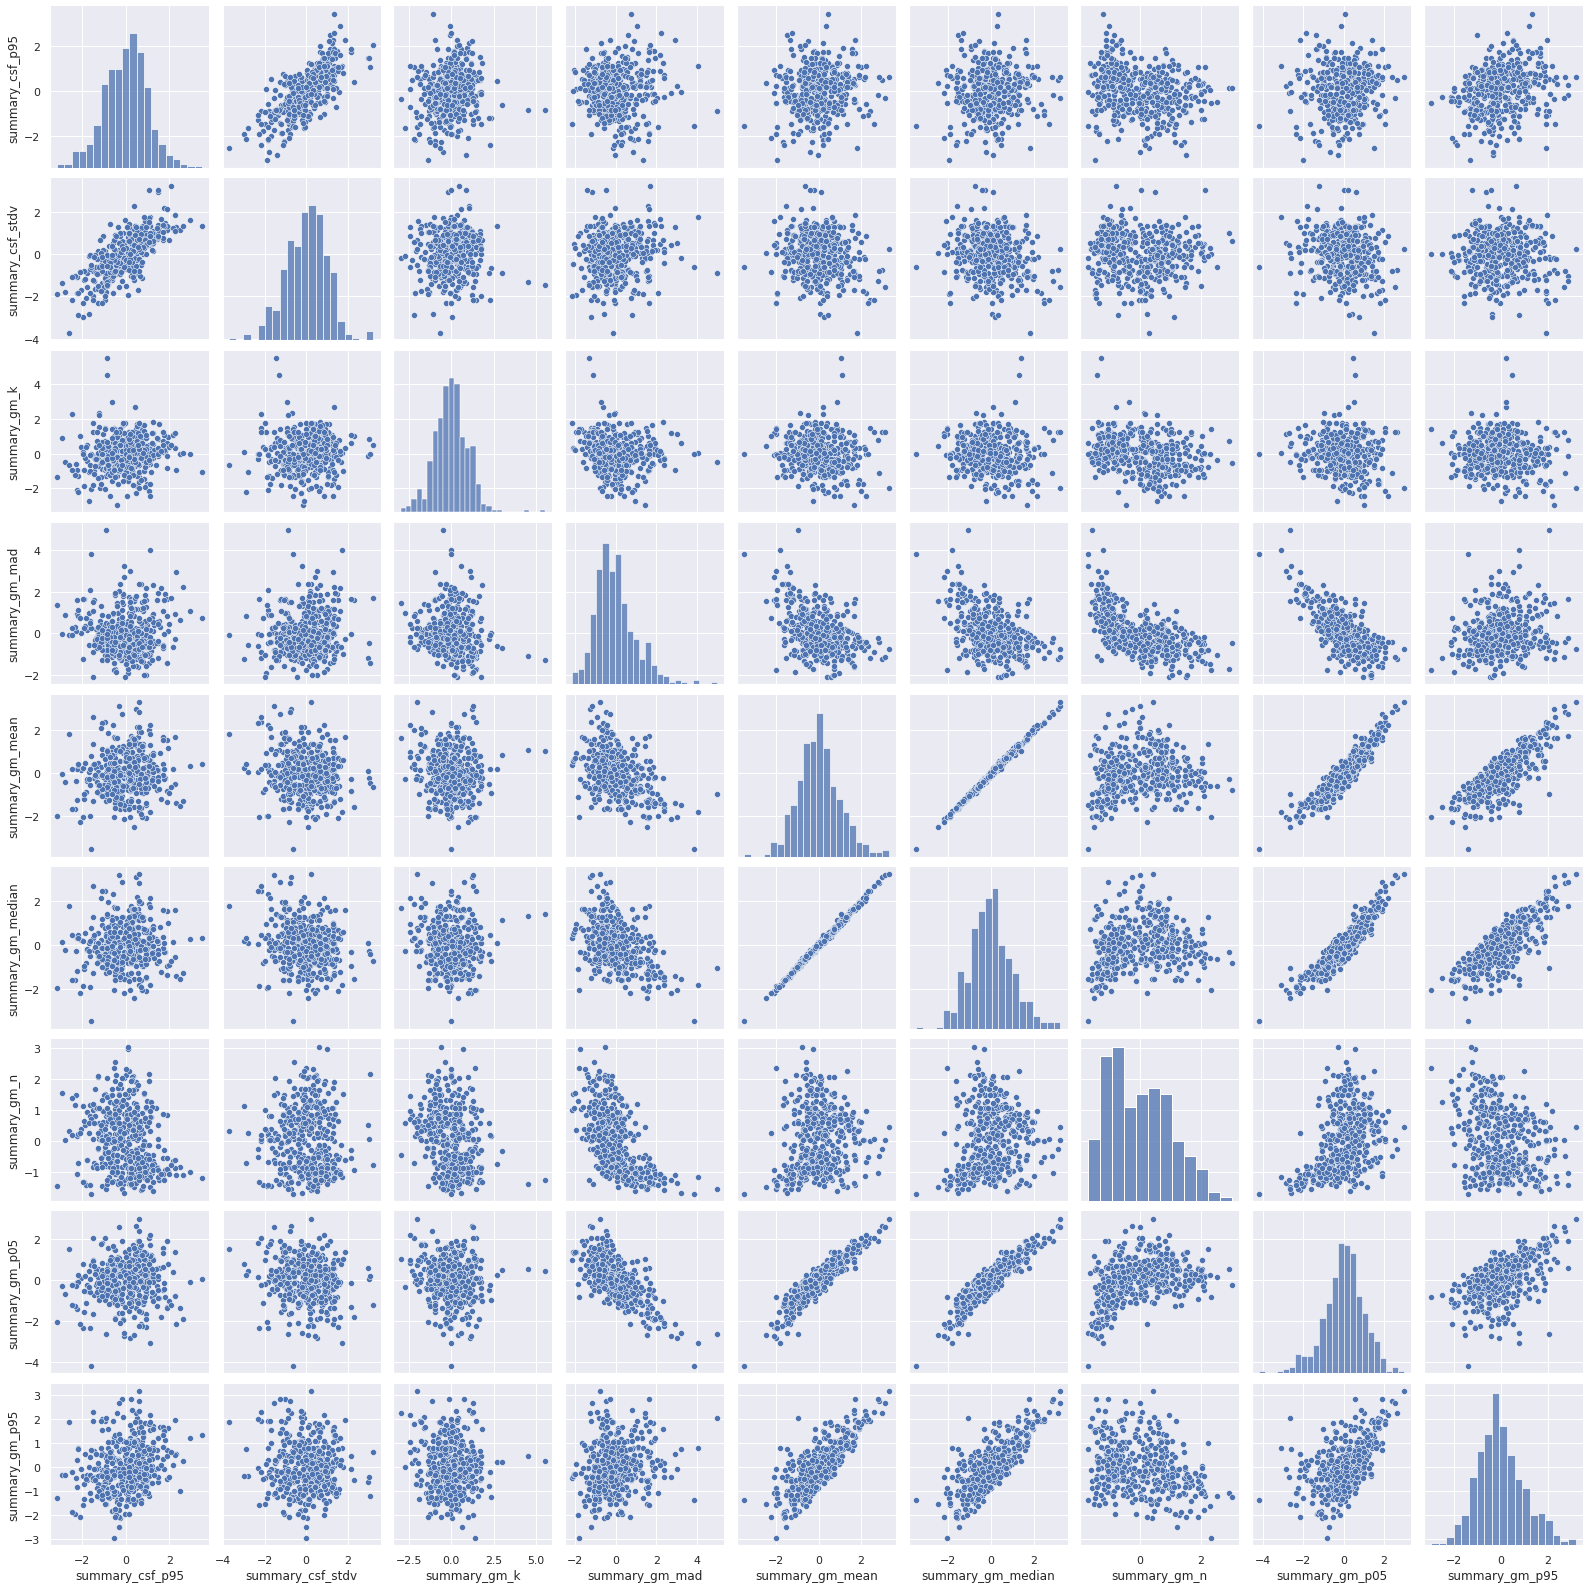

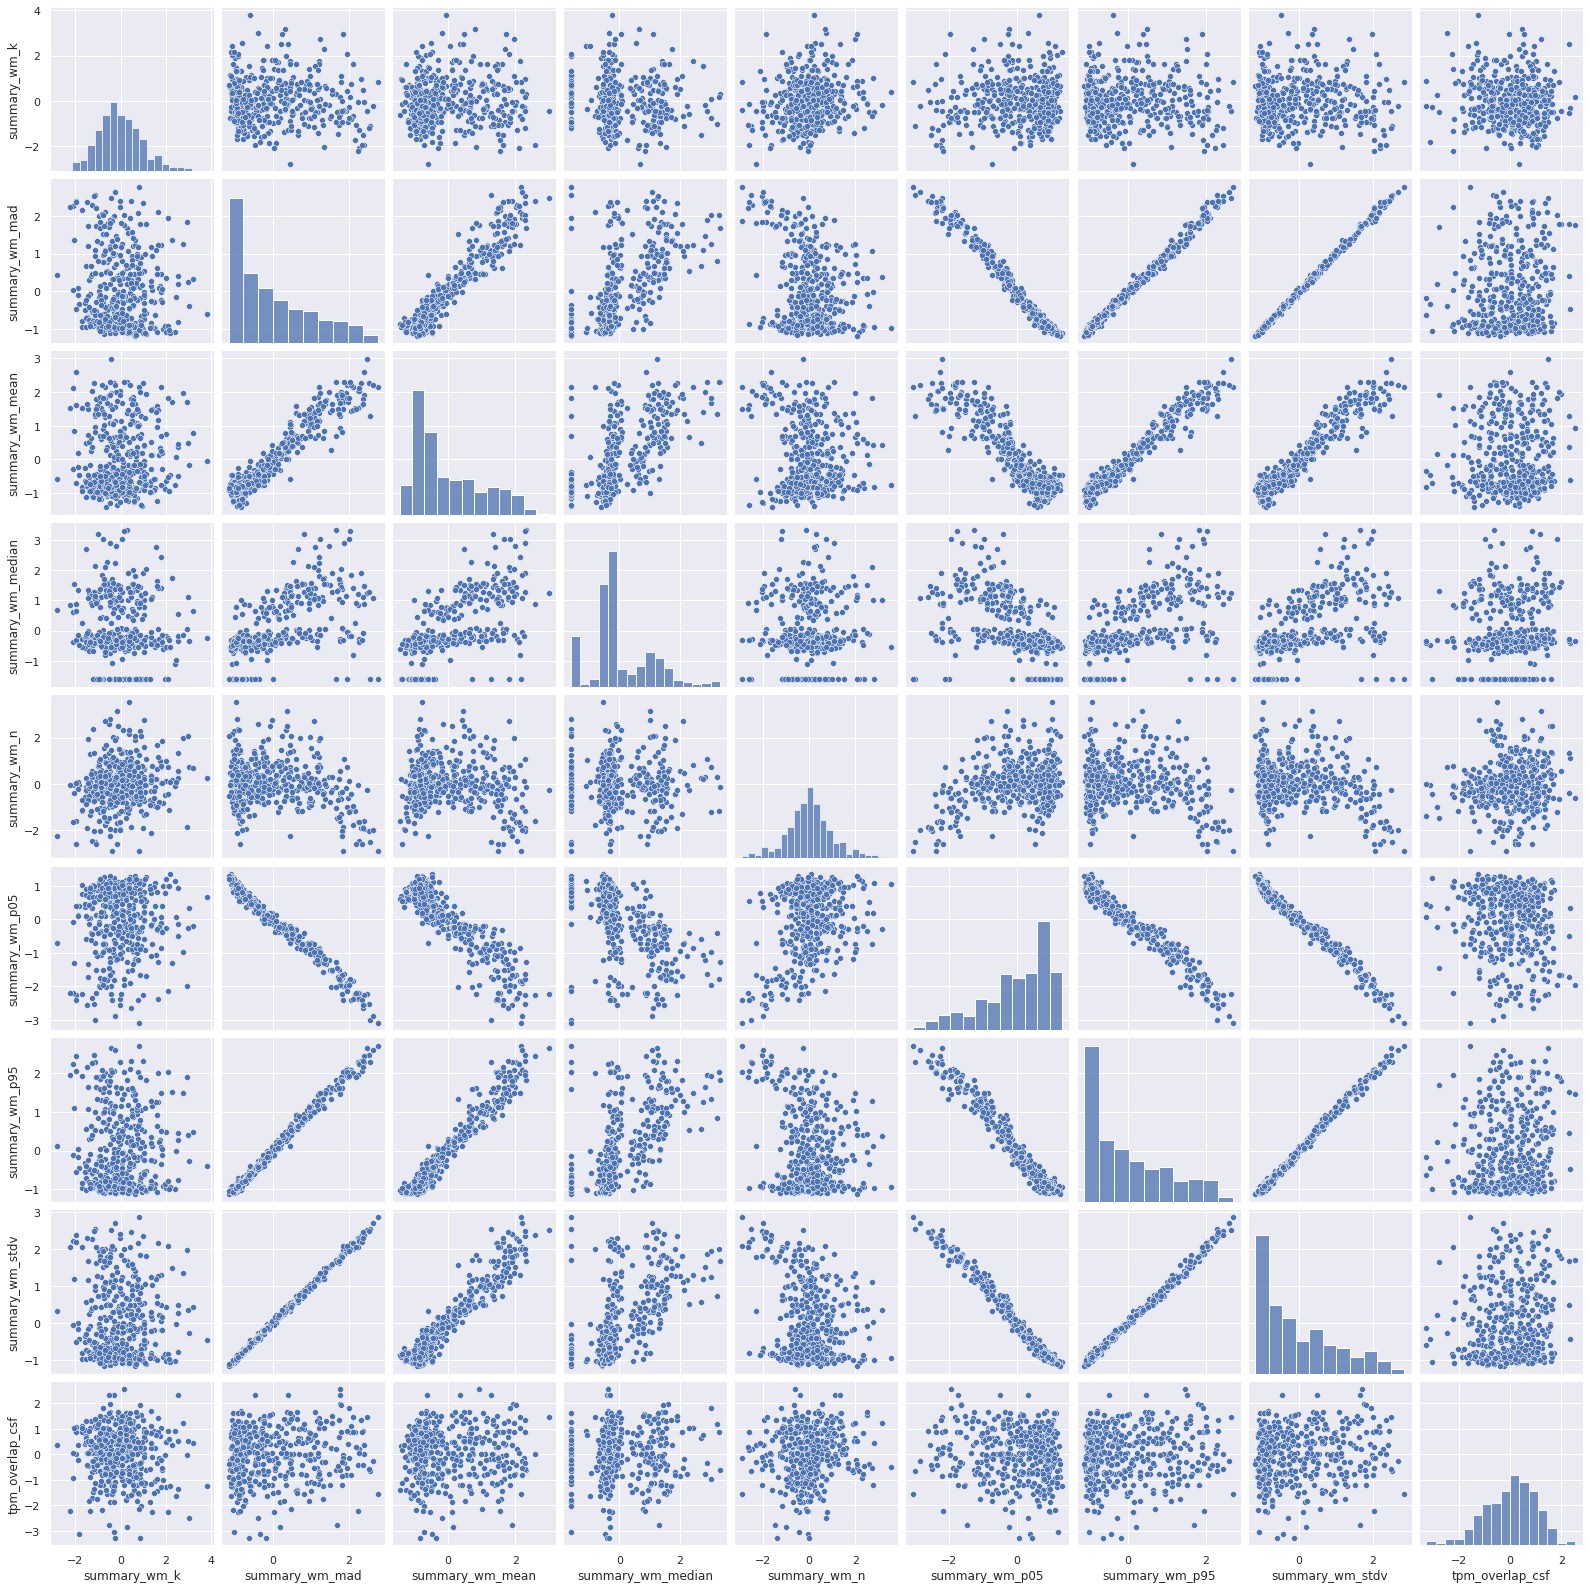

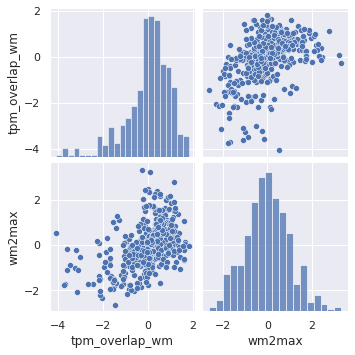

In [70]:
metrics_sets = {f"set{i+1}": list(iqms_scaled.columns[i*10:i*10+9]) for i in range(6)}
metrics_sets["set8"] = list(iqms_scaled.columns[60:])
for metrics_set in metrics_sets.values():
     sns.pairplot(iqms_scaled[metrics_set])

Interesting! There are quite a few non-linear relationships between the IQMs, which we should keep in mind should linear dimension reduction techniques fail. Also note that some metrics are heavily correlated which renders IQMs the perfect candidates for dimensionality reduction. Dimensionality reduction would also help us in our quest to interpret the IQMs by providing a lower dimensional representation. Let's try.

## Dimensionality Reduction

### PCA

The simplest dimension reduction technique is principal component analysis (PCA), which projects the data onto a new set of axis defined by the eigenvectors of the data matrix (principal components). The first principal component corresponds to the direction in which the variance is maximal. For PCA, it is important for all the features to be on the same scale, thus data need to be normalized. Here, as the data are already rescaled, we can directly apply it.

In [71]:
# run PCA
pca = PCA()
iqms_pca = pca.fit_transform(iqms_scaled)

#Caste PCA results as a dataframe
col_names_pca = [f"component{i+1}" for i in range(62)]
iqms_pca = pd.DataFrame(iqms_pca, columns=col_names_pca)

In [72]:
# Plot the two first principal components color-coded by motion condition
fig = px.scatter(iqms_pca, x="component1", y="component2", color=scores["condition"],
 title="Projection of the data colored by motion condition on the two first principal components")
fig.show()

![PCAbyCondition](../figures/PCAbyCondition.png)

In [73]:
#Plot the two first principal components color-coded by manual ratings
fig = px.scatter(iqms_pca, x="component1", y="component2", color=scores["score"],
title="Projection of the data colored by manual ratings on the two first principal components")
fig.show()

![PCAbyScore](../figures/PCAbyScore.png)

We can see that the projection of the data on the two first components already allows us to separate well both the ratings and the conditions. Let's see how much variance those two components explain.

The two first principal components explain 62% of the variance.


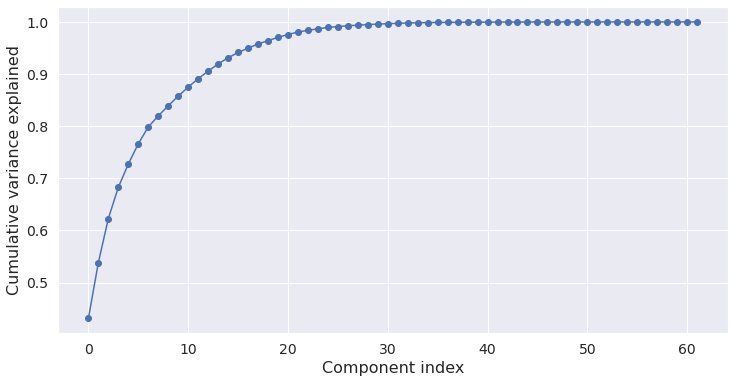

In [74]:
#Extract variance explained by each component
exp_var=pca.explained_variance_ratio_
#Compute cumulative variance explained
cum_exp_var = np.cumsum(exp_var)

#Plot cumulative variance explained
plt.figure(figsize=(12,6))
plt.plot(cum_exp_var, 'bo-')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Component index',fontsize=16)
plt.ylabel('Cumulative variance explained',fontsize=16)

print('The two first principal components explain {:.0f}% of the variance.'.format(cum_exp_var[2]*100))

The two first principal components explain 62% of the variance. If the goal was to do a dimensionality reduction that retains as much variance as possible, we would want to extract more than two components. However, we already saw that the first component is able to separate the different conditions and ratings already quite well. So for exploration purposes, it makes sense to have a look at the loadings of just the first two components. This way, we will get a sense of which variables contribute most to each component.

In [75]:
loadings = pd.DataFrame(pca.components_[:2].T, index=iqms_scaled.columns)
px.imshow(loadings, color_continuous_midpoint=0, color_continuous_scale=px.colors.diverging.RdBu_r,
width=500, height=1300)

![PCAloadings](../figures/PCAloadings.png)

As we can see do the two components capture different information. We already know from the scatterplot that the first component is the one able to separate the conditions/ratings. When looking at the loadings of the first component, we get an idea which of the IQMs influence this component the most. [Here](https://mriqc.readthedocs.io/en/latest/iqms/t1w.html) is an overview of the different measures, that also tells us if higher or lower values indicate a better quality image. E.g., for CJV, lower is better, while for CNR, higher is better. This means that component 1 is related to the "badness" of the image, as the polarity of the loadings of CJV and CNR is opposite to the interpretation of their value.

### t-SNE

t-distributed Stochastic Neighbor Embedding (t-SNE) is another dimension reduction technique. Unlike PCA, it also captures non-linear relationships. It is often used for visualization purposes. Let's run t-SNE to get another visualization of the data in latent space:

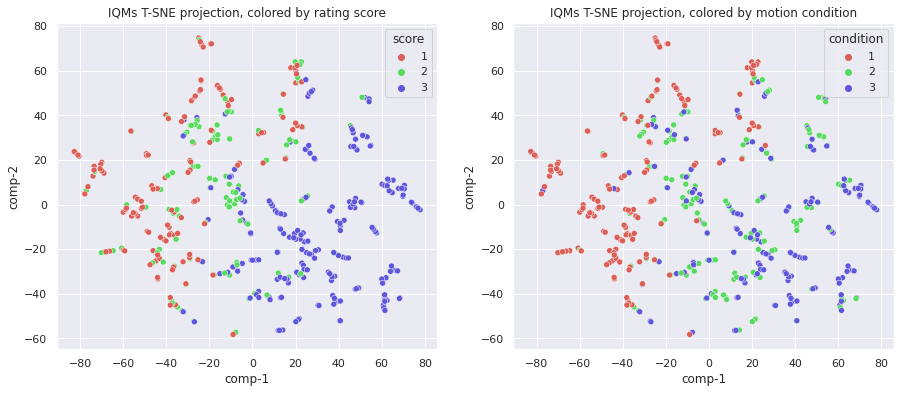

In [76]:
# run TSNE
iqms_embedded = TSNE(n_components=2, learning_rate='auto', init='random' , perplexity=3, random_state=42).fit_transform(iqms_scaled)
# plot TSNE
iqms_embedded = pd.DataFrame(iqms_embedded, columns=["component1", "component2"])
df = pd.DataFrame()
df["score"] = scores["score"].copy()
df["condition"] = scores["condition"].copy()

df["comp-1"] = iqms_embedded["component1"].values
df["comp-2"] = iqms_embedded["component2"].values


fig, axs = plt.subplots(1, 2, figsize=(15, 6))
sns.scatterplot(x="comp-1", y="comp-2", hue="score",
                palette=sns.color_palette("hls", 3),
                data=df, ax=axs[0]).set(title="IQMs T-SNE projection, colored by rating score")
sns.scatterplot(x="comp-1", y="comp-2", hue="condition",
                palette=sns.color_palette("hls", 3),
                data=df, ax=axs[1]).set(title="IQMs T-SNE projection, colored by motion condition")
plt.show()

While different from the PCA components, the separation does not seem to improve. If anything, it is worse, as now both components are needed to separate images with rating score 1 from those with 2 or 3, instead of just one component when using PCA. The same is true when looking at the movement condition.

### Conclusion about dimensionality reduction

We saw using TSNE and PCA that it is possible to separate the IQMs in a lower-dimensional space based on the motion condition or the manual ratings. However, that did not help us interpret the IQMs. We checked the loadings of the principal components, but it is difficult to extract a clear story. Let's try another approach. 

## Classification and Feature Importance

While dimension reduction in general and PCA in particular can give us an idea of which IQMs are useful in telling good from bad quality images, a more direct approach is to use the IQMs as features in a classification task. We will try two supervised machine learning algorithm, namely a logistic regression with elastic-net regularization and support vector classification (SVC).

To make the interpretation of the plots easier, we will moreover binarize our target: no-motion versus motion, meaning that we pulled together in one group both levels of motion.

In [77]:
scores["condition_bin"] = np.where(scores["condition"] == 1, 0, 1)

### Classification approach

To implement SVC and Elastic-net classifications, we will follow the following steps:
 * define a final testing set on which to assess the performance of the classifier with selected hyper-parameters
 * do cross-validation on the remaining data to examine the stability of the best hyper-parameters chosen for each test fold
 
The final test set will be 10% the size of the data, and the cross-validation scheme will be stratified shuffled 10-fold 

In [78]:
test_ratio = 0.1
n_folds = 10

X = iqms_scaled
y = scores["condition_bin"]

**Data split**. The first step of any machine learning method is to split the dataset in a train and a test set. The train set will be used to train the model in a cross-validate fashion. The test set will be used to assess the model accuracy on a set that has not been seen by the model during training.

In [79]:
X_np = X.to_numpy()
y_np = y.to_numpy()
X_cv, X_finaltest, y_cv, y_finaltest = train_test_split(X_np, y_np, test_size=test_ratio, shuffle=True,
                                                          stratify=y_np, random_state=42)

**Cross-validation.** Next, a stratified shuffled 10-fold cross-validation is performed to find the set of best hyperparameters. Stratified means that the folds are made by preserving the percentage of samples for each class. The hyperparameters set selected is the one providing the best performance in the test folds.

In [80]:
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

### Classification using Elastic-Net

We first try to predict the motion condition based on the IQMs using Elastic-Net (Zou and Hastie 2005) logistic regression. It combines L1 and L2 regularization, thus both promoting sparsity of the solution -- which is an advantage for feature selection -- and accounting for feature collinearity.

#### Training the model

We will do a grid search to find the best parameters for our learning algorithm. In this case, these will be the C, which referes to the regularization strength, and the L1 ratio, which is the ratio of the L1 penalty to the L2 penalty (remember that elastic net combines both).

In [81]:
Cs = [ 10.0**p for p in np.linspace(-6, 6, 100)]
l1_ratios = np.linspace(0, 1.0, 41)
n_cpus=20

In [82]:
#Define the model
en_cv = LogisticRegressionCV(max_iter=1000000, penalty='elasticnet', solver="saga", class_weight="balanced",
                             cv=skf, random_state=42, l1_ratios=l1_ratios, Cs=Cs, n_jobs=n_cpus)
                             
#Fit the model to the data using the target
en_cv.fit(X_cv, y_cv)

LogisticRegressionCV(Cs=[1e-06, 1.3219411484660288e-06, 1.747528400007683e-06,
                         2.310129700083158e-06, 3.0538555088334123e-06,
                         4.037017258596558e-06, 5.336699231206313e-06,
                         7.0548023107186455e-06, 9.3260334688322e-06,
                         1.2328467394420658e-05, 1.6297508346206434e-05,
                         2.1544346900318867e-05, 2.8480358684358048e-05,
                         3.7649358067924715e-05, 4.977023564332114e-05,
                         6.579...
                     cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                     l1_ratios=array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
       0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
       0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
       0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
       0.9  , 0.925, 0.95 , 0.975, 1.   ]),
                     max_iter=1000000, n_jobs=20, penalty='elasticnet',
                     random_state=42, solver='saga')

In [83]:
print(f"The best set of paramaters are l1 ratio: {en_cv.l1_ratio_[0]} and C: {en_cv.C_[0]}")

The best set of paramaters are l1 ratio: 0.9500000000000001 and C: 1.5199110829529332


#### Testing the model

To estimate the final model accuracy, we test the model on the hold-out test data and compare it to training accuracy

In [84]:
en_best = LogisticRegression(max_iter=1000000, penalty='elasticnet', solver="saga", class_weight="balanced",
                             l1_ratio=1.0, C=en_cv.C_[0])
en_best.fit(X_cv, y_cv)
print(f"Training accuracy: {accuracy_score(y_cv, en_best.predict(X_cv))}")
print(f"Hold out dataset test accuracy: {accuracy_score(y_finaltest, en_best.predict(X_finaltest))}")

Training accuracy: 0.9821428571428571
Hold out dataset test accuracy: 0.9090909090909091


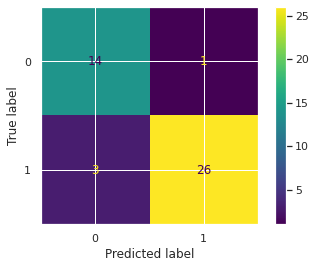

In [85]:
cm = confusion_matrix(y_finaltest, en_best.predict(X_finaltest), labels=en_best.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=en_best.classes_)
disp.plot();

#### Visualizing model coefficients

Inspecting the model coefficients can tell us about what features are important for the model to make its prediction.

In [86]:
bestmodel_coefs_df = pd.DataFrame({"coef": en_best.coef_[0]})
bestmodel_coefs_df["abs_coef"] = bestmodel_coefs_df["coef"].abs()
bestmodel_coefs_df["coef_name"] = iqms_scaled.columns
bestmodel_coefs_df

coef  abs_coef        coef_name
0   0.000000  0.000000              cjv
1   0.000000  0.000000              cnr
2  -0.255507  0.255507              efc
3  -0.576204  0.576204             fber
4   0.000000  0.000000         fwhm_avg
..       ...       ...              ...
57  0.000000  0.000000  summary_wm_stdv
58  0.024427  0.024427  tpm_overlap_csf
59  0.000000  0.000000   tpm_overlap_gm
60  0.000000  0.000000   tpm_overlap_wm
61  1.192198  1.192198           wm2max

[62 rows x 3 columns]

Non-surprinsingly, many coefficients are zero due to the high value of L1 ratio chosen for the best model corresponding to a model favoring L1 penalty. Let's have a look only at the non-zero median features.

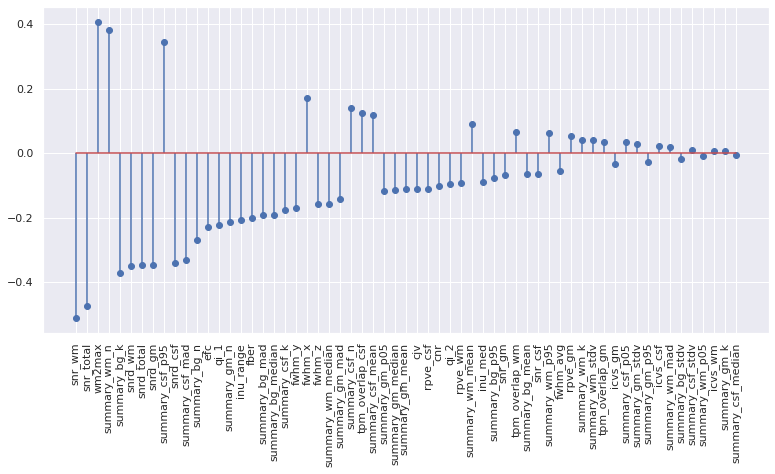

In [101]:
# Sort the coefficients by absolute value and plot them
coefs_sorted_df = bestmodel_coefs_df.sort_values(by='abs_coef',ascending=False)
# Select only non-zero coefficients
coefs_sorted_non0_df = coefs_sorted_df[coefs_sorted_df["abs_coef"]>0]
# Stem plot
plt.figure(figsize=(13,6))
plt.stem("coef", data=coefs_sorted_non0_df[coefs_sorted_non0_df["abs_coef"]>0])
plt.xticks(np.arange(len(coefs_sorted_non0_df)), coefs_sorted_non0_df["coef_name"], rotation='vertical');

We can also visualize them in a polar plot:

In [88]:
%%capture --no-display 
# Do not display warnings

# Visualization in form of polar plot
coefs_sorted_non0_df["positive"] = coefs_sorted_non0_df["coef"] > 0
px.line_polar(coefs_sorted_non0_df, r='abs_coef', theta='coef_name', color='positive', line_close=True, 
              hover_data={"coef": ':.3f', "coef_name": True, "positive": False, "abs_coef": False},
              width=800, height=600)

![PolarPlotElasticNet](../figures/PolarPlotElasticNet.png)

As a conclusion, the most important features to predict motion presence based on the IQMs are the SNR-derived metrics along with the white matter to maximum intensity ratio (wm2max) and a few summary metrics such as the kurtosis of the background (summary_bg_k) or the number of voxels in the white matter (summary_wm_n). Remember that you can find the list of all the IQMs and their definition [here](https://mriqc.readthedocs.io/en/latest/measures.html).

### Classification using Support vector classifier (SVC)

To see if these results also hold when using a different classifier, we follow the same procedure using a Support Vector Machine (SVC).

#### Training the model

In [89]:
svc = LinearSVC(class_weight="balanced", max_iter=100000)

Again, we do a grid search over the parameters in a cross-validated fashion. This time there is just one parameter, the regularization strength (parameter C).

In [90]:
Cs = [ 10.0**p for p in np.linspace(-6, 6, 100)]
n_cpus=20
param_grid = {"C": Cs}
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, n_jobs=n_cpus, cv=skf)
grid_search.fit(X_cv, y_cv)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=LinearSVC(class_weight='balanced', max_iter=100000),
             n_jobs=20,
             param_grid={'C': [1e-06, 1.3219411484660288e-06,
                               1.747528400007683e-06, 2.310129700083158e-06,
                               3.0538555088334123e-06, 4.037017258596558e-06,
                               5.336699231206313e-06, 7.0548023107186455e-06,
                               9.3260334688322e-06, 1.232...
                               4.977023564332114e-05, 6.579332246575683e-05,
                               8.697490026177834e-05, 0.00011497569953977356,
                               0.0001519911082952933, 0.00020092330025650479,
                               0.00026560877829466864, 0.0003511191734215131,
                               0.0004641588833612782, 0.0006135907273413176,
                               0.0008111308307896872, 0.0010722672220103231,
                               0.0014174741629268048, 0.001873817422860385,
                               0.0024770763559917113, 0.0032745491628777285, ...]})

In [91]:
print(f"The best training accuracy reached in the grid search is: {grid_search.best_score_}")


The best training accuracy reached in the grid search is: 0.9695512820512822


In [92]:
print(f"The best hyperparamater C is: {grid_search.best_params_['C']}")

The best hyperparamater C is: 0.21544346900318867


#### Testing the model

To estimate the final prediction accuracy, we again test the model on the hold-out test data and compare it to training accuracy.

In [93]:
svc_best = LinearSVC(class_weight="balanced", max_iter=100000, C=grid_search.best_params_['C'])
svc_best.fit(X_cv, y_cv)
print(f"Training accuracy: {accuracy_score(y_cv, svc_best.predict(X_cv))}")
print(f"Hold out dataset test accuracy: {accuracy_score(y_finaltest, svc_best.predict(X_finaltest))}")

Training accuracy: 0.9846938775510204
Hold out dataset test accuracy: 0.9545454545454546


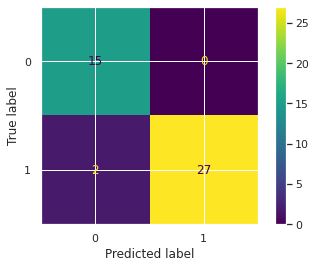

In [94]:
cm = confusion_matrix(y_finaltest, svc_best.predict(X_finaltest), labels=svc_best.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc_best.classes_)
disp.plot()

#### Visualizing model coefficients

Again inspecting the model coefficients can tell us about what features are important for the model to make its prediction.

In [95]:
bestmodel_coefs_df = pd.DataFrame({"coef": svc_best.coef_[0]})
bestmodel_coefs_df["abs_coef"] = bestmodel_coefs_df["coef"].abs()
bestmodel_coefs_df["coef_name"] = iqms_scaled.columns
bestmodel_coefs_df

coef  abs_coef        coef_name
0  -0.110652  0.110652              cjv
1  -0.103316  0.103316              cnr
2  -0.230126  0.230126              efc
3  -0.199722  0.199722             fber
4  -0.056577  0.056577         fwhm_avg
..       ...       ...              ...
57  0.040874  0.040874  summary_wm_stdv
58  0.124602  0.124602  tpm_overlap_csf
59  0.035250  0.035250   tpm_overlap_gm
60  0.067022  0.067022   tpm_overlap_wm
61  0.407527  0.407527           wm2max

[62 rows x 3 columns]

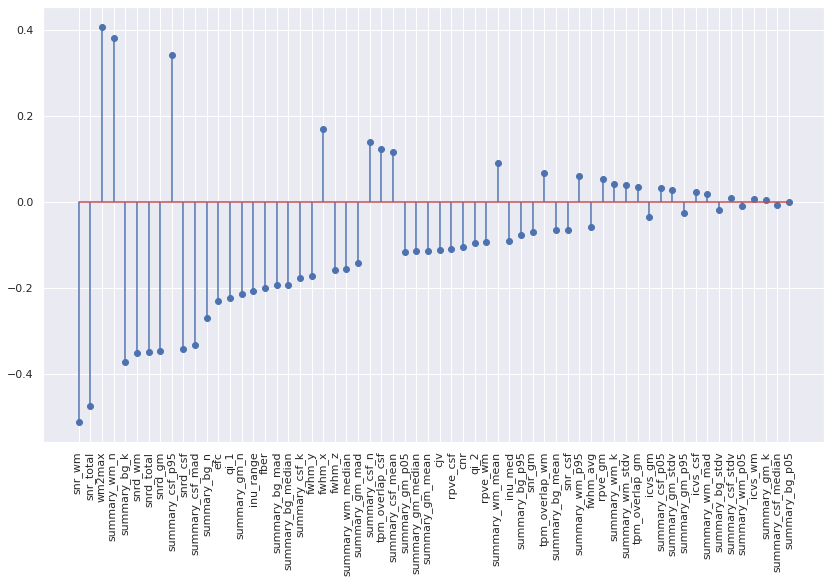

In [96]:
#Sort the coefficients by absolute value and plot them
coefs_sorted_df = bestmodel_coefs_df.sort_values(by='abs_coef',ascending=False)
#Stem plot
plt.figure(figsize=(14,8))
plt.stem("coef", data=coefs_sorted_df)
plt.xticks(np.arange(len(coefs_sorted_df)), coefs_sorted_df["coef_name"], rotation='vertical');

In [97]:
%%capture --no-display 
# Do not display warnings

# Visualization in form of polar plot
coefs_sorted_df["positive"] = coefs_sorted_df["coef"] > 0
px.line_polar(coefs_sorted_df, r='abs_coef', theta='coef_name', color='positive', line_close=True, 
              hover_data={"coef": ':.3f', "coef_name": True, "positive": False, "abs_coef": False},
              width=800, height=600)

![PolarPlotSVC_full](../figures/PolarPlotSVC_full.png)

Because the plot is too crowded to be readable let's define a threshold on the coefficient weight. Remember that SVC unlike Elastic-Net do not perform L1 regularization, that is why we end up with many more non-zero coefficients.

In [98]:
%%capture --no-display 
# Do not display warnings

# Visualize feature with highest weight. Visually we can see clusters with weight > 0.1
coef_thr = 0.1
px.line_polar(coefs_sorted_df[coefs_sorted_df["abs_coef"]>coef_thr], r='abs_coef', theta='coef_name',
              color='positive', line_close=True, width=800, height=600,
              hover_data={"coef": ':.3f', "coef_name": True, "positive": False, "abs_coef": False},)

Let us put side by side the polar plot from the SVC and the ElasticNet to ease comparison.

SVC            |  ElasticNet
:-------------------------:|:-------------------------:
![PolarPlotSVC_restricted](../figures/PolarPlotSVC_restricted.png) | ![PolarPlotElasticNet](../figures/PolarPlotElasticNet.png)

We see that our results from the Elastic-Net classification holds and SNR-derived metrics remain the most important features to predict motion presence based on the IQMs. The other important metrics remain stable as well.

## Conclusion

Both supervised classification methods give converging evidence that SNR-derived metrics are the most important features to classify motion strength based on the IQMs. Coming back to our original question of interpreting the IQMs, this result means that SNR-derived metrics are important for capturing motion artifacts. We have thus contributed to the understanding and interpretation of the IQMs. We hope that this notebook can now help you perform the analysis of your own IQMs and as such that you can help us further improve the interpretability of the IQMs generated by MRIQC.

## Acknowledgements

This notebook has been initiated at the [Brainhack Global Geneva 2022](https://brainhack.ch) and springs from a joint effort of the project team composed by 
Mikkel Schöttner, Céline Provins, Michael Dayan, Vivi Nastase, Jenny Lunde and Oriol Mãne Benach. The results presented in this notebook have been submitted as an abstract to OHBM Montréal 2023. The abstract is entitled "Signal-to-noise ratio estimates predict head motion presence in T1-weighted MRI" and is available at [https://osf.io/7vqzr/](https://osf.io/7vqzr/). The full exploratory analysis we performed in the context of this project can be found at [https://github.com/brainhack-ch/interpret-iqms](https://github.com/brainhack-ch/interpret-iqms).

## References

Nárai, Ádám, Petra Hermann, Tibor Auer, Péter Kemenczky, János Szalma, István    Homolya, Eszter Somogyi, Pál Vakli, Béla Weiss, and Zoltán Vidnyánszky. 2022. “Movement-Related Artefacts (MR-ART) Dataset of Matched Motion-Corrupted and Clean Structural MRI Brain Scans.” Scientific Data 9 (1): 630. https://doi.org/10.1038/s41597-022-01694-8.

Zou, Hui, and Trevor Hastie. 2005. “Regularization and Variable Selection via the Elastic Net.” Journal of the Royal Statistical Society: Series B (Statistical Methodology) 67 (2): 301–20. https://doi.org/10.1111/j.1467-9868.2005.00503.x.